# 《人工神经网络理论、设计及应用》代码实践-第六章 竞争学习神经网络
<hr>

#### 本章需要安装的第三方包或软件
```
minisom
```

### 6.1 竞争学习的概念与原理

#### Page112 例6.1的代码实现（计算结果不完全相同，原因待查）

In [1]:
# Page112 例6.1的代码实现（计算结果不同，原因待查）

import numpy as np

def cartesian_to_polar(cartesian):
    """将笛卡尔坐标转换为极坐标"""
    x, y = cartesian
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x) * 180 / np.pi  # 转换为角度
    return round(r,2), round(theta,4)

def normalize_weights(W):
    """对权重矩阵中的每个向量进行归一化"""
    norms = np.linalg.norm(W, axis=1, keepdims=True)
    # 避免除以零的情况
    norms[norms == 0] = 1
    W_normalized = W / norms
    return W_normalized

def update_weights(X, W, lr, iterations=4):
    """执行竞争学习并更新权重"""
    for i in range(iterations):
        total_error = 0
        
        for sample in X:
            # 计算每个神经元与样本之间的欧氏距离
            distances = np.linalg.norm(W - sample, axis=1)

            # 找到距离最小的神经元（获胜者）
            winner_idx = np.argmin(distances)

            # 更新获胜者的权重
            W[winner_idx] += lr * (sample - W[winner_idx])

            # 归一化权重
            W = normalize_weights(W)

            # 累加误差
            total_error += min(distances)

            # 打印当前迭代次数和极坐标形式的权值
            print(f"Iteration {i+1}:")
            for j, weight in enumerate(W):
                r, theta = cartesian_to_polar(weight)
                print(f"  Neuron {j+1} Weights: (r={r}, θ={theta:.2f}°)")

    return W

# 给定的数据点和初始权值
X = np.array([[0.8, 0.6], [0.1736, -0.9848], [0.707, 0.707], [0.342, -0.9397], [0.6, 0.8]])
W = np.array([[1.0, 0.0], [-1.0, 0.0]])
lr = 0.5

# 打印各输入向量的极坐标
for i in range(X.shape[0]):
    theta=cartesian_to_polar(X[i])
    print(f"笛卡尔坐标：{X[i]}的极坐标为：{theta}")
print()
    
# 进行4轮共20次权值计算，并打印结果
updated_W = update_weights(X, W, lr, iterations=4)

笛卡尔坐标：[0.8 0.6]的极坐标为：(1.0, 36.8699)
笛卡尔坐标：[ 0.1736 -0.9848]的极坐标为：(1.0, -80.0026)
笛卡尔坐标：[0.707 0.707]的极坐标为：(1.0, 45.0)
笛卡尔坐标：[ 0.342  -0.9397]的极坐标为：(1.0, -70.0012)
笛卡尔坐标：[0.6 0.8]的极坐标为：(1.0, 53.1301)

Iteration 1:
  Neuron 1 Weights: (r=1.0, θ=18.43°)
  Neuron 2 Weights: (r=1.0, θ=180.00°)
Iteration 1:
  Neuron 1 Weights: (r=1.0, θ=-30.78°)
  Neuron 2 Weights: (r=1.0, θ=180.00°)
Iteration 1:
  Neuron 1 Weights: (r=1.0, θ=7.11°)
  Neuron 2 Weights: (r=1.0, θ=180.00°)
Iteration 1:
  Neuron 1 Weights: (r=1.0, θ=-31.45°)
  Neuron 2 Weights: (r=1.0, θ=180.00°)
Iteration 1:
  Neuron 1 Weights: (r=1.0, θ=10.84°)
  Neuron 2 Weights: (r=1.0, θ=180.00°)
Iteration 2:
  Neuron 1 Weights: (r=1.0, θ=23.86°)
  Neuron 2 Weights: (r=1.0, θ=180.00°)
Iteration 2:
  Neuron 1 Weights: (r=1.0, θ=23.86°)
  Neuron 2 Weights: (r=1.0, θ=-130.00°)
Iteration 2:
  Neuron 1 Weights: (r=1.0, θ=34.43°)
  Neuron 2 Weights: (r=1.0, θ=-130.00°)
Iteration 2:
  Neuron 1 Weights: (r=1.0, θ=34.43°)
  Neuron 2 Weights: (r=1.0

#### Page112 例6.1的代码实现，完整了训练，添加了误差下降（可以观察到恒定学习率时的权值振荡现象）、分类结果可视化

In [2]:
# Page112 例6.1的代码实现，完整了训练，添加了误差下降（可以观察到恒定学习率时的权值振荡现象）、分类结果可视化

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib qt5

def cartesian_to_polar(cartesian):
    """将笛卡尔坐标转换为极坐标"""
    x, y = cartesian
    r = np.sqrt(x**2 + y**2)
    #theta = np.arctan2(y, x)  # 保持弧度制
    theta = np.arctan2(y, x) * 180 / np.pi  # 转换为角度
    return np.round(r, 2), np.round(theta, 2)

def normalize_weights(W):
    """对权重矩阵中的每个向量进行归一化"""
    norms = np.linalg.norm(W, axis=1, keepdims=True)
    norms[norms == 0] = 1
    W_normalized = W / norms
    return W_normalized

def update_weights(X, W, lr, iterations=20):
    """执行竞争学习并更新权重"""
    error_history = []  # 记录每次迭代后的平均误差
    weight_history = [W.copy()]  # 记录每次迭代后的权重
    
    for i in range(iterations):
        total_error = 0
        
        for sample in X:
            distances = np.linalg.norm(W - sample, axis=1)
            winner_idx = np.argmin(distances)
            W[winner_idx] += lr * (sample - W[winner_idx])
            W = normalize_weights(W)
            total_error += min(distances)

            avg_error = total_error / len(X)
            error_history.append(avg_error)
            weight_history.append(W.copy())
    
            # 打印当前迭代的权重（极坐标形式，角度用度数）
            print(f"Iteration {i+1}:")
            for j, weight in enumerate(W):
                r, theta = cartesian_to_polar(weight)
                print(f"  Neuron {j+1} Weight: r={r:.2f}, θ={theta:.2f}°")

    return weight_history, error_history

def plot_error_history(ax, error_history):
    """绘制误差随迭代次数的变化"""
    epochs = range(1, len(error_history) + 1)
    ax.clear()
    ax.plot(epochs, error_history, marker='o', linestyle='-')
    ax.set_title('Error Function Over Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Distance Error')
    ax.grid(True)

def classify_samples(X, W):
    """根据最终权重对所有样本进行分类"""
    classifications = []
    for sample in X:
        distances = np.linalg.norm(W - sample, axis=1)
        winner_idx = np.argmin(distances)
        classifications.append(winner_idx)
    return classifications



def plot_polar_animation(fig, weight_history, X, error_history, interval=500):
    """绘制极坐标动画，显示权重向量和样本数据点及分类的变化过程"""
    ax_polar = fig.add_subplot(121, polar=True)
    ax_error = fig.add_subplot(122)
    
    def init():
        ax_polar.clear()
        ax_error.clear()
        plot_error_history(ax_error, error_history)
        return []

    def update(frame):
        ax_polar.clear()
        
        # 获取当前帧的权重向量
        current_W = weight_history[frame]
        
        # 动态分类所有样本点
        classifications = classify_samples(X, current_W)

        # 绘制数据点及从原点出发的带箭头线段（每帧重新绘制以保证一致性）
        colors = ['b', 'g']
        markers = ['o', 's']
        for i, (sample, classification) in enumerate(zip(X, classifications)):
            r, theta_degrees = cartesian_to_polar(sample)
            theta_rad = np.radians(theta_degrees)  # 转换回弧度制用于绘图
            ax_polar.annotate("", xy=(theta_rad, r), xytext=(0, 0),
                             arrowprops=dict(facecolor=colors[classification], edgecolor=colors[classification],
                                             arrowstyle="->", lw=2))
            ax_polar.scatter([theta_rad], [r], c=[colors[classification]], marker=markers[classification])
            ax_polar.text(theta_rad, r, f'({sample[0]:.2f},{sample[1]:.2f})\nr={r:.2f}, θ={theta_degrees:.2f}°',
                          fontsize=9, ha='right', va='bottom')

        # 绘制当前帧的权重向量
        for j, weight in enumerate(current_W):
            r, theta_degrees = cartesian_to_polar(weight)
            theta_rad = np.radians(theta_degrees)  # 转换回弧度制用于绘图
            ax_polar.annotate("", xy=(theta_rad, r), xytext=(0, 0),
                              arrowprops=dict(facecolor='r', edgecolor='r',
                                              arrowstyle="->", lw=2, linestyle='--'))
            ax_polar.text(theta_rad, r, f'Neuron {j+1}\nr={r:.2f}, θ={theta_degrees:.2f}°',
                          fontsize=9, ha='left', va='top', color='r')

        # 更新误差变化图
        plot_error_history(ax_error, error_history[:frame+1])

        # 设置图表标题和标签
        ax_polar.set_title('Polar Plot of Weight Vectors and Data Points Over Iterations')
        ax_polar.set_theta_zero_location('N')  # 设置θ=0的位置在顶部
        ax_polar.set_theta_direction(-1)  # 逆时针方向为正方向
        ax_polar.set_rlabel_position(22.5)  # 移动半径标签位置

        return []

    ani = FuncAnimation(fig, update, frames=len(weight_history), init_func=init, blit=True, repeat=False, interval=interval)
    
    return ani

# 给定的数据点和初始权值，确保初始权值是浮点数类型
X = np.array([[0.8, 0.6], [0.1736, -0.9848], [0.707, 0.707], [0.342, -0.9397], [0.6, 0.8]], dtype=float)
W = np.array([[1, 0], [-1, 0]], dtype=float)
lr = 0.5

# 进行20次权值计算，并记录误差历史
weight_history, error_history = update_weights(X, W, lr, iterations=20)

# 分类所有样本并打印结果
updated_W=weight_history[-1]
classifications = classify_samples(X, updated_W)
for i, (sample, classification) in enumerate(zip(X, classifications), start=1):
    print(f"笛卡尔坐标： ({sample})即极坐标:{cartesian_to_polar(sample)}归属于分类神经元: Classified to Neuron {classification + 1}")


# 创建一个包含两个子图的图形
fig = plt.figure(figsize=(16, 8))

# 绘制极坐标动画，显示权重向量和样本数据点及分类的变化过程
ani = plot_polar_animation(fig, weight_history, X, error_history, interval=500)

plt.tight_layout()
plt.show()

libGL error: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: iris
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


Iteration 1:
  Neuron 1 Weight: r=1.00, θ=18.43°
  Neuron 2 Weight: r=1.00, θ=180.00°
Iteration 1:
  Neuron 1 Weight: r=1.00, θ=-30.78°
  Neuron 2 Weight: r=1.00, θ=180.00°
Iteration 1:
  Neuron 1 Weight: r=1.00, θ=7.10°
  Neuron 2 Weight: r=1.00, θ=180.00°
Iteration 1:
  Neuron 1 Weight: r=1.00, θ=-31.45°
  Neuron 2 Weight: r=1.00, θ=180.00°
Iteration 1:
  Neuron 1 Weight: r=1.00, θ=10.84°
  Neuron 2 Weight: r=1.00, θ=180.00°
Iteration 2:
  Neuron 1 Weight: r=1.00, θ=23.86°
  Neuron 2 Weight: r=1.00, θ=180.00°
Iteration 2:
  Neuron 1 Weight: r=1.00, θ=23.86°
  Neuron 2 Weight: r=1.00, θ=-130.00°
Iteration 2:
  Neuron 1 Weight: r=1.00, θ=34.43°
  Neuron 2 Weight: r=1.00, θ=-130.00°
Iteration 2:
  Neuron 1 Weight: r=1.00, θ=34.43°
  Neuron 2 Weight: r=1.00, θ=-100.00°
Iteration 2:
  Neuron 1 Weight: r=1.00, θ=43.78°
  Neuron 2 Weight: r=1.00, θ=-100.00°
Iteration 3:
  Neuron 1 Weight: r=1.00, θ=40.32°
  Neuron 2 Weight: r=1.00, θ=-100.00°
Iteration 3:
  Neuron 1 Weight: r=1.00, θ=40.32°

#### Page116 例6.2动物属性特征映射

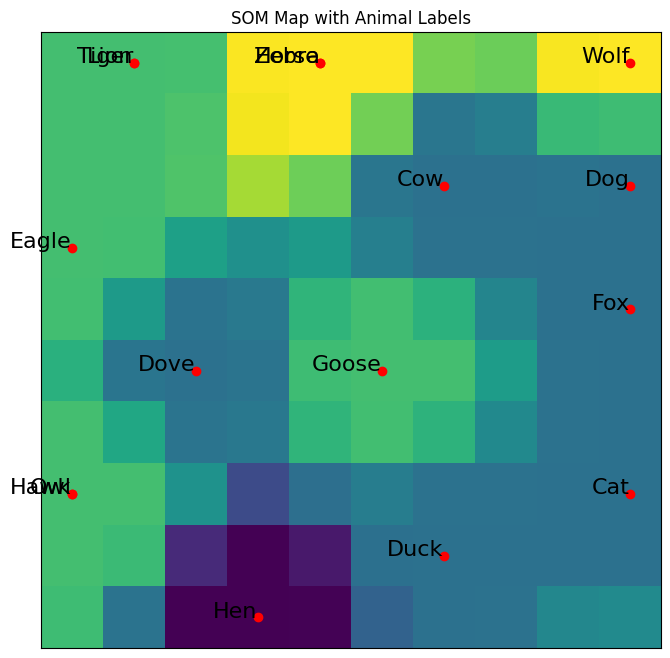

In [1]:
# Page116 例6.2动物属性特征映射

import numpy as np
import matplotlib.pyplot as plt

# 输入数据及对应的动物名称
#分类维度及度量值：小、中、大、2只腿、4只腿、毛、蹄、鬃毛、羽毛、猎、跑、飞、泳
data = {
    "Dove":  [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    "Hen":   [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "Duck":  [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
    "Goose": [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1],
    "Owl":   [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
    "Hawk":  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
    "Eagle": [0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
    "Fox":   [0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
    "Dog":   [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
    "Wolf":  [0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0],
    "Cat":   [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0],
    "Tiger": [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
    "Lion":  [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0],
    "Horse": [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
    "Zebra": [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
    "Cow":   [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
}

# 提取数据和标签
X = np.array(list(data.values()))
labels = list(data.keys())

# 参数设置
input_dim = X.shape[1]
map_size = (10, 10)  # SOM地图大小
learning_rate = 0.3
num_epochs = 1000
sigma = 1.5  # 初始邻域半径

# 归一化输入数据
def normalize_data(data):
    return data / np.linalg.norm(data, axis=1, keepdims=True)

X_normalized = normalize_data(X)

# 初始化权重矩阵
weights = np.random.rand(map_size[0], map_size[1], input_dim)

# 归一化初始权值
def normalize_weights(weights):
    return weights / np.linalg.norm(weights, axis=-1, keepdims=True)

weights_normalized = normalize_weights(weights)

# 计算欧氏距离
def euclidean_distance(x, w):
    return np.linalg.norm(x - w, axis=-1)

# 计算高斯核函数
def gaussian_kernel(distance, sigma):
    return np.exp(-(distance ** 2) / (2 * sigma ** 2))

# 训练过程
for epoch in range(num_epochs):
    for x in X_normalized:
        # 计算所有权重向量与输入向量的欧氏距离
        distances = euclidean_distance(x, weights_normalized)
        
        # 选择距离最小的权重向量作为获胜神经元
        winner_index = np.unravel_index(np.argmin(distances), distances.shape)
        
        # 计算所有神经元与获胜神经元的距离
        distance_matrix = np.linalg.norm(np.indices(weights_normalized.shape[:2]).transpose(1, 2, 0) - np.array(winner_index), axis=-1)
        
        # 计算高斯核函数
        influence = gaussian_kernel(distance_matrix, sigma)
        
        # 更新权重向量
        weights_normalized += learning_rate * influence[:, :, np.newaxis] * (x - weights_normalized)
    
    # 调整学习率和邻域半径
    learning_rate *= 0.99
    sigma *= 0.99

# 可视化训练后的神经元相邻特性
def plot_som_map(weights, X, labels):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(weights.mean(axis=-1), aspect='auto', cmap='viridis')
    
    # 绘制数据点
    for x, label in zip(X, labels):
        distances = euclidean_distance(x, weights)
        winner_index = np.unravel_index(np.argmin(distances), distances.shape)
        ax.scatter(winner_index[1], winner_index[0], color='red', marker='o')
        ax.text(winner_index[1], winner_index[0], label, fontsize=16, ha='right')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('SOM Map with Animal Labels')
    plt.show()

# 可视化训练后的SOM地图
plot_som_map(weights_normalized, X_normalized, labels)

#### Page117 例6.3 SOM网用于字符排序

Training SOM: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 621.46epoch/s]


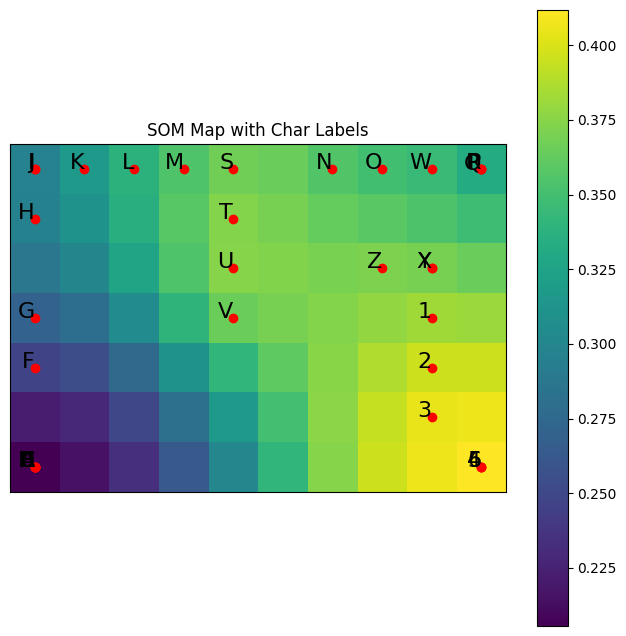

In [6]:
# Page117 例6.3 SOM网用于字符排序

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入 tqdm 库

# 输入数据相互连接关系
data = {
    "A":  [1,0,0,0,0],
    "B":  [2,0,0,0,0],
    "C":  [3,0,0,0,0],
    "D":  [4,0,0,0,0],
    "E":  [5,0,0,0,0],
    "F":  [3,1,0,0,0],
    "G":  [3,2,0,0,0],
    "H":  [3,3,0,0,0],
    "I":  [3,4,0,0,0],
    "J":  [3,5,0,0,0],
    "K":  [3,3,1,0,0],
    "L":  [3,3,2,0,0],
    "M":  [3,3,3,0,0],
    "N":  [3,3,4,0,0],
    "O":  [3,3,5,0,0],
    "P":  [3,3,6,0,0],
    "Q":  [3,3,7,0,0],
    "R":  [3,3,8,0,0],
    "S":  [3,3,3,1,0],
    "T":  [3,3,3,2,0],
    "U":  [3,3,3,3,0],
    "V":  [3,3,3,4,0],
    "W":  [3,3,6,1,0],
    "X":  [3,3,6,2,0],
    "Y":  [3,3,6,3,0],
    "Z":  [3,3,6,4,0],
    "1":  [3,3,6,2,1],
    "2":  [3,3,6,2,2],
    "3":  [3,3,6,2,3],
    "4":  [3,3,6,2,4],
    "5":  [3,3,6,2,5],
    "6":  [3,3,6,2,6]
}

# 提取数据和标签
X = np.array(list(data.values()))
labels = list(data.keys())

# 参数设置
input_dim = X.shape[1]
map_size = (7, 10)  # SOM地图大小
learning_rate = 0.1
num_epochs = 1000
#initial_sigma = max(map_size) / 10.0  # 初始邻域半径
initial_sigma = max(map_size) / 2.0  # 初始邻域半径


# 固定随机种子
np.random.seed(0)

# 归一化输入数据
def normalize_data(data):
    return data / np.linalg.norm(data, axis=1, keepdims=True)

X_normalized = normalize_data(X)

# 初始化权重矩阵
weights = np.random.rand(map_size[0], map_size[1], input_dim)

# 归一化初始权值
def normalize_weights(weights):
    return weights / np.linalg.norm(weights, axis=-1, keepdims=True)

weights_normalized = normalize_weights(weights)

# 计算曼哈顿距离
def manhattan_distance(x, w):
    return np.sum(np.abs(x - w), axis=-1)

# 计算高斯核函数
def gaussian_kernel(distance, sigma):
    return np.exp(-(distance ** 2) / (2 * sigma ** 2))

# 训练过程
for epoch in tqdm(range(num_epochs), desc="Training SOM", unit="epoch"):  # 使用 tqdm 显示进度
    # 随机打乱数据顺序
    indices = np.random.permutation(len(X_normalized))
    for idx in indices:
        x = X_normalized[idx]
        
        # 计算所有权重向量与输入向量的曼哈顿距离
        distances = manhattan_distance(x, weights_normalized)
        
        # 选择距离最小的权重向量作为获胜神经元
        winner_index = np.unravel_index(np.argmin(distances), distances.shape)
        
        # 计算所有神经元与获胜神经元的距离
        distance_matrix = np.linalg.norm(np.indices(weights_normalized.shape[:2]).transpose(1, 2, 0) - np.array(winner_index), axis=-1)
        
        # 计算高斯核函数
        influence = gaussian_kernel(distance_matrix, initial_sigma * np.exp(-epoch / num_epochs))
        
        # 更新权重向量
        weights_normalized += learning_rate * influence[:, :, np.newaxis] * (x - weights_normalized)
    
    # 调整学习率和邻域半径
    learning_rate *= 0.9  # 更慢的衰减速率
    initial_sigma *= 0.9  # 更慢的衰减速率

# 可视化训练后的神经元相邻特性
def plot_som_map(weights, X, labels):
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(weights.mean(axis=-1), aspect='auto', cmap='viridis')
    plt.colorbar(im, ax=ax)  # 添加颜色条
    
    # 绘制数据点
    for x, label in zip(X, labels):
        distances = manhattan_distance(x, weights)
        winner_index = np.unravel_index(np.argmin(distances), distances.shape)
        ax.scatter(winner_index[1], winner_index[0], color='red', marker='o')
        ax.text(winner_index[1], winner_index[0], label, fontsize=16, ha='right')
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('SOM Map with Char Labels')
    ax.set_aspect('equal')  # 使x轴和y轴的数据单位比例为1:1
    plt.show()

# 可视化训练后的SOM地图
plot_som_map(weights_normalized, X_normalized, labels)

#### 书中代码-Page120 6.3.2

In [ ]:
# Page120 6.3.2
# 此程序用到的neupy库需要特定的python及其它相关库版本，如果报错，可建立单独的虚拟环境运行。

import numpy as np
import matplotlib.pyplot as plt
from neupy import algorithms, utils

# 使用ggplot样式
plt.style.use('ggplot')

# 输入数据
X = np.array([
    [0.1961, 0.9806],
    [-0.1961, 0.9806],
    [0.9806, 0.1961],
    [0.9806, -0.1961],
    [-0.5812, -0.8137],
    [-0.8137, -0.5812]
])

# 初始化SOFM网络
sofmnet = algorithms.SOFM(
    n_inputs=2,
    n_outputs=3,
    step=0.5,
    show_epoch=20,
    shuffle_data=True,
    verbose=True,
    learning_radius=0,
    feature_grid=(3, 1)
)

# 绘制原始数据点
plt.plot(X[:, 0], X[:, 1], 'ko', label='Input Data')

# 训练SOFM网络
sofmnet.train(X, epochs=100)

# 打印开始绘制的信息
print("> Start plotting")

# 设置图形的边界
plt.xlim(-1, 1.2)
plt.ylim(-1, 1.2)

# 绘制训练后的权重向量
plt.plot(sofmnet.weight[0, :], sofmnet.weight[1, :], 'bx', label='SOFM Weights')

# 显示图例
plt.legend()

# 显示图形
plt.show()

# 输出每个数据点的预测结果
for data in X:
    prediction = sofmnet.predict(np.reshape(data, (1, 2)))
    print(f"Data: {data}, Prediction: {prediction}")

#### 延展-Page120 6.3.2 程序的pytorch包实现

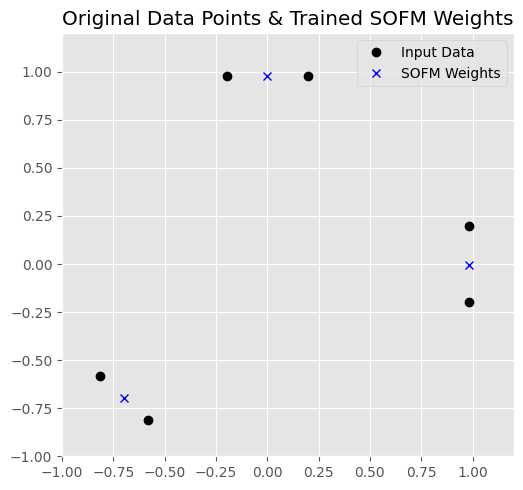

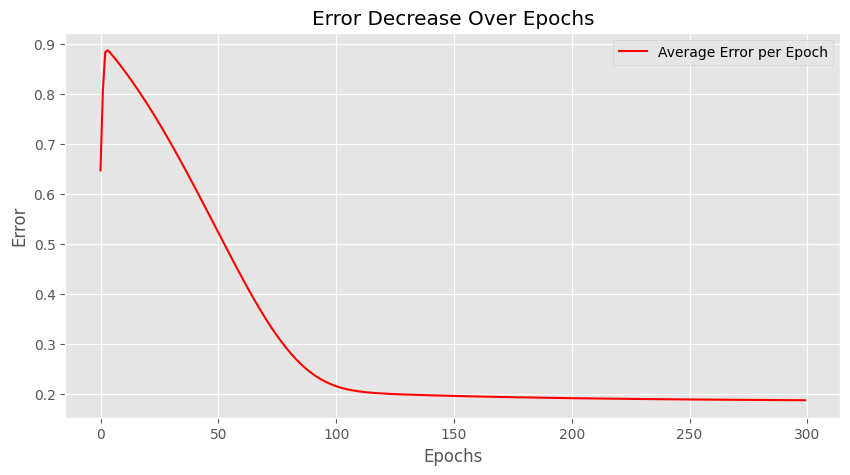

Data: [0.1961 0.9806], Prediction: 2
Data: [-0.1961  0.9806], Prediction: 2
Data: [0.9806 0.1961], Prediction: 0
Data: [ 0.9806 -0.1961], Prediction: 0
Data: [-0.5812 -0.8137], Prediction: 1
Data: [-0.8137 -0.5812], Prediction: 1


In [8]:
# Page120 6.3.2 扩展程序实现
# 为了便于在pytorch虚拟环境测试，改用pytorch包实现,增加误差下降可视化

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 使用ggplot样式
plt.style.use('ggplot')

# 输入数据
X = np.array([
    [0.1961, 0.9806],
    [-0.1961, 0.9806],
    [0.9806, 0.1961],
    [0.9806, -0.1961],
    [-0.5812, -0.8137],
    [-0.8137, -0.5812]
])

# 将输入数据转换为PyTorch张量
X_tensor = torch.tensor(X, dtype=torch.float32)

class SOFM(nn.Module):
    def __init__(self, n_inputs, n_outputs, learning_rate=0.5, sigma=1.0, decay_rate=0.99):
        super(SOFM, self).__init__()
        self.weights = nn.Parameter(torch.randn(n_outputs, n_inputs))
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.decay_rate = decay_rate
        
    def forward(self, x):
        # 计算所有权重向量与输入向量的欧氏距离
        distances = torch.norm(x - self.weights, dim=1)
        return distances
    
    def train_step(self, x):
        # 计算所有权重向量与输入向量的欧氏距离
        distances = self.forward(x)
        
        # 找到获胜神经元（最小距离）
        winner_index = torch.argmin(distances)
        
        # 更新获胜神经元及其邻域的权重
        for i in range(self.weights.shape[0]):
            distance_to_winner = abs(i - winner_index.item())
            influence = np.exp(-distance_to_winner ** 2 / (2 * self.sigma ** 2))
            self.weights.data[i] += self.learning_rate * influence * (x - self.weights.data[i])
        
        # 返回最小距离作为误差
        return distances[winner_index].item()
    
    def predict(self, x):
        with torch.no_grad():
            distances = self.forward(x)
            winner_index = torch.argmin(distances)
            return winner_index.item()

# 初始化SOFM网络
sofmnet = SOFM(n_inputs=2, n_outputs=3, learning_rate=0.5, sigma=1.0)

# 绘制原始数据点
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(X[:, 0], X[:, 1], 'ko', label='Input Data')
#plt.xlim(-1, 1.2)
#plt.ylim(-1, 1.2)
#plt.legend()
#plt.title('Original Data Points')

# 训练SOFM网络并记录误差
num_epochs = 300
errors = []
for epoch in range(num_epochs):
    epoch_error = 0
    for data in X_tensor:
        error = sofmnet.train_step(data)
        epoch_error += error
    avg_epoch_error = epoch_error / len(X_tensor)
    errors.append(avg_epoch_error)
    
    # 打印当前epoch的信息
    '''
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}: Learning Rate: {sofmnet.learning_rate:.6f}, Sigma: {sofmnet.sigma:.6f}")
        print(f"Weights:\n{sofmnet.weights.detach().numpy()}")
        print(f"Average Error: {avg_epoch_error:.6f}\n")
    '''
    
    # 衰减学习率和邻域半径
    sofmnet.learning_rate *= sofmnet.decay_rate
    sofmnet.sigma *= sofmnet.decay_rate

# 绘制训练后的权重向量
#plt.subplot(1, 2, 2)
plt.plot(sofmnet.weights[:, 0].detach().numpy(), sofmnet.weights[:, 1].detach().numpy(), 'bx', label='SOFM Weights')
plt.xlim(-1, 1.2)
plt.ylim(-1, 1.2)
plt.legend()
plt.title('Original Data Points & Trained SOFM Weights')

# 显示图形
plt.tight_layout()
plt.show()

# 可视化误差下降情况
plt.figure(figsize=(10, 5))
plt.plot(errors, 'r-', label='Average Error per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error Decrease Over Epochs')
plt.legend()
plt.show()

# 输出每个数据点的预测结果
for data in X_tensor:
    prediction = sofmnet.predict(data)
    print(f"Data: {data.numpy()}, Prediction: {prediction}")

### 6.4 自组织特征映射网络的设计与应用

#### Page125 6.4.2.1 SOM用于物流中心城市分类评价

In [9]:
# 数据格式处理（Excel录入后粘贴到文本）
import numpy as np

# 设置 numpy 打印选项，禁用科学计数法
np.set_printoptions(suppress=True, precision=6)

# 原始数据
data = """
北京	27527	2738.3	1494.83	3055.63	30500
天津	22073	2663.56	782.33	1465.65	28151
石家庄	25584	467.42	156.02	763.46	12415
唐山	19387	338.67	95.73	199.69	14522
太原	13919	304.13	141.94	155.22	15170
呼和浩特	13738	82.23	69.27	108.12	2415
沈阳	21736	729.04	590.26	1752.4	15156
大连	34659	1003.56	431.83	728.08	19736
长春	24799	900.26	309.75	173.99	10346
哈尔滨	20737	402.73	360.38	762.94	8814
上海	40788	6935.57	1531.89	3921.2	49499
南京	26697	1579.21	401.2	1253.73	14120
徐州	19727	295.73	108.17	187.39	7124
连云港	17869	112.18	47.94	134.89	4096
杭州	31784	1615.63	373.28	1788.29	15841
宁波	46471	751.58	167.7	529.68	11182
温州	29781	381.93	233.44	272.84	6292
合肥	19770	330.14	140.14	328.98	2903
福州	35570	379.51	209.72	613.24	7280
厦门	42039	803.29	186.55	620.47	2547
南昌	19923	238.82	14.09	348.21	3246
济南	25642	616.97	323.08	462.39	13057
青岛	29682	1212.02	182.8	598.06	29068
烟台	21017	298.73	92.71	227.39	8178
郑州	17330	261.8	215.63	402.98	7373
武汉	17882	1020.84	685.82	1452	16244
长沙	26327	241.76	269.93	369.83	7550
衡阳	12386	61.53	63.95	72.65	3004
广州	42828	2446.97	1166.1	3214.19	24500
深圳	152099	3079.63	609.26	801.06	5167
汕头	19414	192.93	112.96	280.94	1443
湛江	15290	228.45	99.08	149.16	5524
南宁	17715	109.39	142.08	264.32	3371
柳州	17598	256.76	68.93	159.44	3397
海口	24782	100.13	81.03	142.54	2018
成都	22956	412.23	400.56	754.07	23724
重庆	9778	870.82	389.6	823.72	29470
贵阳	13176	207.95	108.93	285.27	4885
昆明	24554	303.78	227.44	428.64	12084
西安	16002	449.14	323.37	558.27	7728
兰州	16629	354.3	163.97	374.9	5401
西宁	7261	38	48.95	91.14	1837
银川	12779	77.74	41.22	53.16	1573
乌鲁木齐	19793	251.19	129.05	277.8	9283
"""

# 将数据按行分割
rows = data.strip().split("\n")

# 将每行数据按制表符分割，并转换为列表
data_list = [row.split("\t") for row in rows]

# 提取城市名称（字符串）和数值部分（浮点数）
cities = np.array([row[0] for row in data_list])  # 城市名称
values = np.array([list(map(float, row[1:])) for row in data_list])  # 数值部分

# 组合为完整的 numpy 数组（城市名称和数值）
full_data = np.array(data_list)

# 输出结果
print("城市名称数组：")
print(cities)
print("\n数值数组：")
print(values)
print("\n完整数据数组：")
print(full_data)

城市名称数组：
['北京' '天津' '石家庄' '唐山' '太原' '呼和浩特' '沈阳' '大连' '长春' '哈尔滨' '上海' '南京' '徐州'
 '连云港' '杭州' '宁波' '温州' '合肥' '福州' '厦门' '南昌' '济南' '青岛' '烟台' '郑州' '武汉' '长沙'
 '衡阳' '广州' '深圳' '汕头' '湛江' '南宁' '柳州' '海口' '成都' '重庆' '贵阳' '昆明' '西安' '兰州'
 '西宁' '银川' '乌鲁木齐']

数值数组：
[[ 27527.     2738.3    1494.83   3055.63  30500.  ]
 [ 22073.     2663.56    782.33   1465.65  28151.  ]
 [ 25584.      467.42    156.02    763.46  12415.  ]
 [ 19387.      338.67     95.73    199.69  14522.  ]
 [ 13919.      304.13    141.94    155.22  15170.  ]
 [ 13738.       82.23     69.27    108.12   2415.  ]
 [ 21736.      729.04    590.26   1752.4   15156.  ]
 [ 34659.     1003.56    431.83    728.08  19736.  ]
 [ 24799.      900.26    309.75    173.99  10346.  ]
 [ 20737.      402.73    360.38    762.94   8814.  ]
 [ 40788.     6935.57   1531.89   3921.2   49499.  ]
 [ 26697.     1579.21    401.2    1253.73  14120.  ]
 [ 19727.      295.73    108.17    187.39   7124.  ]
 [ 17869.      112.18     47.94    134.89   4096.  ]
 [ 31784.  

SOM 归类结果：
节点 (0, 2) 包含的城市: 北京, 上海, 广州
节点 (0, 1) 包含的城市: 天津
节点 (1, 1) 包含的城市: 石家庄, 长春, 哈尔滨, 济南, 郑州, 长沙, 昆明, 西安
节点 (2, 1) 包含的城市: 唐山, 太原, 乌鲁木齐
节点 (2, 0) 包含的城市: 呼和浩特, 徐州, 连云港, 合肥, 南昌, 烟台, 衡阳, 汕头, 湛江, 南宁, 柳州, 海口, 贵阳, 兰州, 西宁, 银川
节点 (1, 2) 包含的城市: 沈阳, 南京, 杭州, 武汉
节点 (2, 2) 包含的城市: 大连, 青岛, 成都, 重庆
节点 (1, 0) 包含的城市: 宁波, 温州, 福州, 厦门
节点 (0, 0) 包含的城市: 深圳


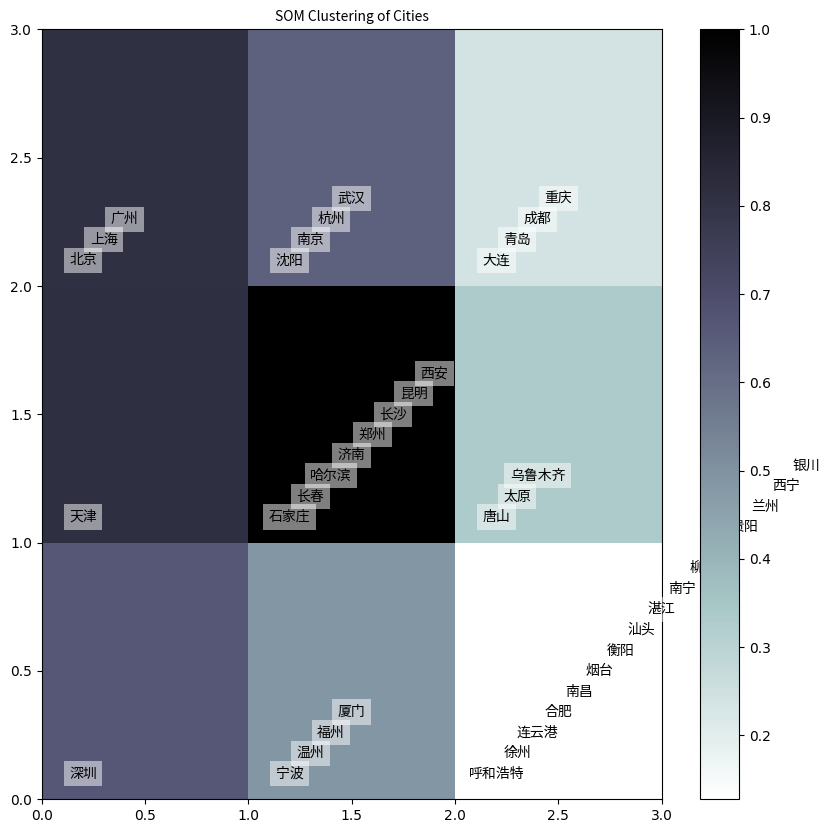

In [37]:
# 使用MiniSom包，以便建立比较参考，验证后序其它实现的正确性

import numpy as np
import pandas as pd
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import MinMaxScaler

# 设置中文字体路径（根据系统字体路径调整）
# 适用于Windows环境的代码，非本环境请注释以下两行代码。
#plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
#plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

# 以下代码测试、适用于Ubuntu22.04的Linux环境，非本环境请注释以下两行代码。
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 例如 Noto Sans CJK 字体路径
my_font = FontProperties(fname=font_path)

# 原始数据
data = np.array([
    ['北京', '27527', '2738.3', '1494.83', '3055.63', '30500'],
    ['天津', '22073', '2663.56', '782.33', '1465.65', '28151'],
    ['石家庄', '25584', '467.42', '156.02', '763.46', '12415'],
    ['唐山', '19387', '338.67', '95.73', '199.69', '14522'],
    ['太原', '13919', '304.13', '141.94', '155.22', '15170'],
    ['呼和浩特', '13738', '82.23', '69.27', '108.12', '2415'],
    ['沈阳', '21736', '729.04', '590.26', '1752.4', '15156'],
    ['大连', '34659', '1003.56', '431.83', '728.08', '19736'],
    ['长春', '24799', '900.26', '309.75', '173.99', '10346'],
    ['哈尔滨', '20737', '402.73', '360.38', '762.94', '8814'],
    ['上海', '40788', '6935.57', '1531.89', '3921.2', '49499'],
    ['南京', '26697', '1579.21', '401.2', '1253.73', '14120'],
    ['徐州', '19727', '295.73', '108.17', '187.39', '7124'],
    ['连云港', '17869', '112.18', '47.94', '134.89', '4096'],
    ['杭州', '31784', '1615.63', '373.28', '1788.29', '15841'],
    ['宁波', '46471', '751.58', '167.7', '529.68', '11182'],
    ['温州', '29781', '381.93', '233.44', '272.84', '6292'],
    ['合肥', '19770', '330.14', '140.14', '328.98', '2903'],
    ['福州', '35570', '379.51', '209.72', '613.24', '7280'],
    ['厦门', '42039', '803.29', '186.55', '620.47', '2547'],
    ['南昌', '19923', '238.82', '14.09', '348.21', '3246'],
    ['济南', '25642', '616.97', '323.08', '462.39', '13057'],
    ['青岛', '29682', '1212.02', '182.8', '598.06', '29068'],
    ['烟台', '21017', '298.73', '92.71', '227.39', '8178'],
    ['郑州', '17330', '261.8', '215.63', '402.98', '7373'],
    ['武汉', '17882', '1020.84', '685.82', '1452', '16244'],
    ['长沙', '26327', '241.76', '269.93', '369.83', '7550'],
    ['衡阳', '12386', '61.53', '63.95', '72.65', '3004'],
    ['广州', '42828', '2446.97', '1166.1', '3214.19', '24500'],
    ['深圳', '152099', '3079.63', '609.26', '801.06', '5167'],
    ['汕头', '19414', '192.93', '112.96', '280.94', '1443'],
    ['湛江', '15290', '228.45', '99.08', '149.16', '5524'],
    ['南宁', '17715', '109.39', '142.08', '264.32', '3371'],
    ['柳州', '17598', '256.76', '68.93', '159.44', '3397'],
    ['海口', '24782', '100.13', '81.03', '142.54', '2018'],
    ['成都', '22956', '412.23', '400.56', '754.07', '23724'],
    ['重庆', '9778', '870.82', '389.6', '823.72', '29470'],
    ['贵阳', '13176', '207.95', '108.93', '285.27', '4885'],
    ['昆明', '24554', '303.78', '227.44', '428.64', '12084'],
    ['西安', '16002', '449.14', '323.37', '558.27', '7728'],
    ['兰州', '16629', '354.3', '163.97', '374.9', '5401'],
    ['西宁', '7261', '38', '48.95', '91.14', '1837'],
    ['银川', '12779', '77.74', '41.22', '53.16', '1573'],
    ['乌鲁木齐', '19793', '251.19', '129.05', '277.8', '9283']
])

# 将城市名称替换为汉语拼音
cities = data[:, 0]
data = data[:, 1:].astype(float)

# 数据归一化（按列归一化）
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# 构建SOM模型
som = MiniSom(x=3, y=3, input_len=data_normalized.shape[1], sigma=1.0, learning_rate=0.8)
som.random_weights_init(data_normalized)

# 第一阶段训练：学习率0.9，训练1000次
som.train_random(data_normalized, 1000, verbose=False)

# 第二阶段训练：学习率0.02，继续训练
som.learning_rate = 0.02
som.train_random(data_normalized, 1000, verbose=False)

# 打印归类结果
# 创建一个字典来存储每个节点的城市列表
node_to_cities = {}

# 遍历每个城市，找到其对应的节点
for i, city in enumerate(cities):
    winner = som.winner(data_normalized[i])
    node_key = (winner[0], winner[1])  # 使用节点坐标作为键
    if node_key not in node_to_cities:
        node_to_cities[node_key] = []
    node_to_cities[node_key].append(city)

# 打印每个节点对应的城市
print("SOM 归类结果：")
for node, cities_in_node in node_to_cities.items():
    print(f"节点 {node} 包含的城市: {', '.join(cities_in_node)}")

# 可视化SOM聚类结果
plt.figure(figsize=(10, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # 距离图
plt.colorbar()

# 标记每个城市的位置
for node, cities_in_node in node_to_cities.items():
    x, y = node
    for i, city in enumerate(cities_in_node):
        plt.text(x + 0.2+ i*0.1, y + 0.1 + i * 0.08, city, ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=0.5, lw=0), fontproperties=my_font)
        
plt.title('SOM Clustering of Cities', fontproperties=my_font)
plt.show()

#### 延展-仅使用numpy包实现SOM神经网络（便于观察原理）

SOM 归类结果：
节点 (2, 2) 包含的城市: 北京, 上海, 广州
节点 (1, 2) 包含的城市: 天津, 沈阳, 武汉
节点 (0, 0) 包含的城市: 石家庄, 长春, 哈尔滨, 济南, 昆明, 西安
节点 (1, 0) 包含的城市: 唐山, 太原, 徐州, 温州, 烟台, 郑州, 长沙, 兰州, 乌鲁木齐
节点 (2, 0) 包含的城市: 呼和浩特, 连云港, 合肥, 南昌, 衡阳, 汕头, 湛江, 南宁, 柳州, 海口, 贵阳, 西宁, 银川
节点 (0, 2) 包含的城市: 大连, 青岛, 成都, 重庆
节点 (2, 1) 包含的城市: 南京, 杭州
节点 (1, 1) 包含的城市: 宁波, 福州, 厦门
节点 (0, 1) 包含的城市: 深圳


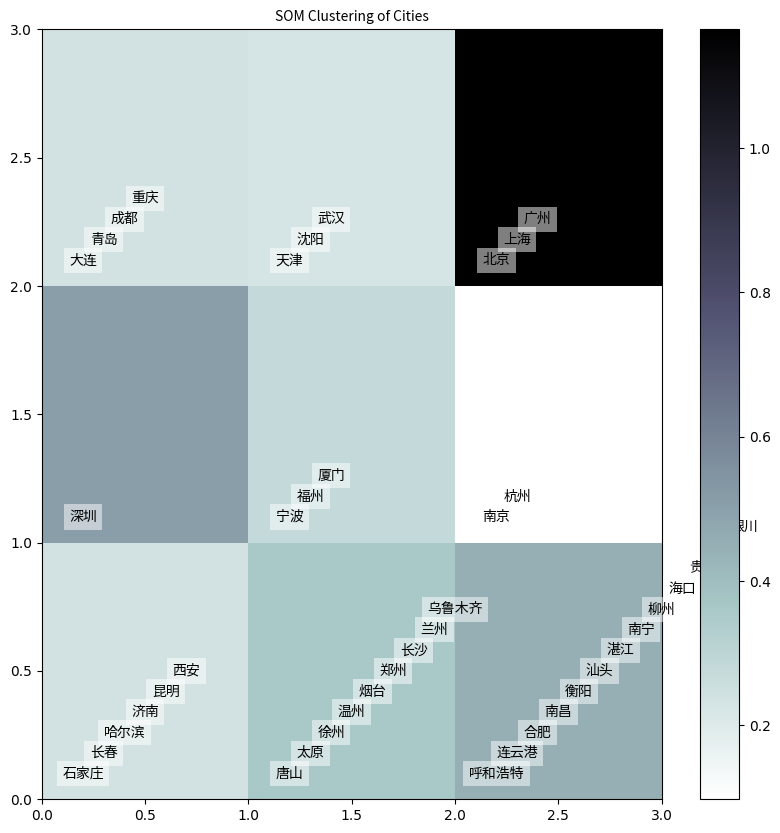

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import MinMaxScaler

# 设置中文字体路径（根据系统字体路径调整）
# 适用于Windows环境的代码，非本环境请注释以下两行代码。
#plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
#plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

# 以下代码测试、适用于Ubuntu22.04的Linux环境，非本环境请注释以下两行代码。
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 例如 Noto Sans CJK 字体路径
my_font = FontProperties(fname=font_path)

# 原始数据
data = np.array([
    ['北京', '27527', '2738.3', '1494.83', '3055.63', '30500'],
    ['天津', '22073', '2663.56', '782.33', '1465.65', '28151'],
    ['石家庄', '25584', '467.42', '156.02', '763.46', '12415'],
    ['唐山', '19387', '338.67', '95.73', '199.69', '14522'],
    ['太原', '13919', '304.13', '141.94', '155.22', '15170'],
    ['呼和浩特', '13738', '82.23', '69.27', '108.12', '2415'],
    ['沈阳', '21736', '729.04', '590.26', '1752.4', '15156'],
    ['大连', '34659', '1003.56', '431.83', '728.08', '19736'],
    ['长春', '24799', '900.26', '309.75', '173.99', '10346'],
    ['哈尔滨', '20737', '402.73', '360.38', '762.94', '8814'],
    ['上海', '40788', '6935.57', '1531.89', '3921.2', '49499'],
    ['南京', '26697', '1579.21', '401.2', '1253.73', '14120'],
    ['徐州', '19727', '295.73', '108.17', '187.39', '7124'],
    ['连云港', '17869', '112.18', '47.94', '134.89', '4096'],
    ['杭州', '31784', '1615.63', '373.28', '1788.29', '15841'],
    ['宁波', '46471', '751.58', '167.7', '529.68', '11182'],
    ['温州', '29781', '381.93', '233.44', '272.84', '6292'],
    ['合肥', '19770', '330.14', '140.14', '328.98', '2903'],
    ['福州', '35570', '379.51', '209.72', '613.24', '7280'],
    ['厦门', '42039', '803.29', '186.55', '620.47', '2547'],
    ['南昌', '19923', '238.82', '14.09', '348.21', '3246'],
    ['济南', '25642', '616.97', '323.08', '462.39', '13057'],
    ['青岛', '29682', '1212.02', '182.8', '598.06', '29068'],
    ['烟台', '21017', '298.73', '92.71', '227.39', '8178'],
    ['郑州', '17330', '261.8', '215.63', '402.98', '7373'],
    ['武汉', '17882', '1020.84', '685.82', '1452', '16244'],
    ['长沙', '26327', '241.76', '269.93', '369.83', '7550'],
    ['衡阳', '12386', '61.53', '63.95', '72.65', '3004'],
    ['广州', '42828', '2446.97', '1166.1', '3214.19', '24500'],
    ['深圳', '152099', '3079.63', '609.26', '801.06', '5167'],
    ['汕头', '19414', '192.93', '112.96', '280.94', '1443'],
    ['湛江', '15290', '228.45', '99.08', '149.16', '5524'],
    ['南宁', '17715', '109.39', '142.08', '264.32', '3371'],
    ['柳州', '17598', '256.76', '68.93', '159.44', '3397'],
    ['海口', '24782', '100.13', '81.03', '142.54', '2018'],
    ['成都', '22956', '412.23', '400.56', '754.07', '23724'],
    ['重庆', '9778', '870.82', '389.6', '823.72', '29470'],
    ['贵阳', '13176', '207.95', '108.93', '285.27', '4885'],
    ['昆明', '24554', '303.78', '227.44', '428.64', '12084'],
    ['西安', '16002', '449.14', '323.37', '558.27', '7728'],
    ['兰州', '16629', '354.3', '163.97', '374.9', '5401'],
    ['西宁', '7261', '38', '48.95', '91.14', '1837'],
    ['银川', '12779', '77.74', '41.22', '53.16', '1573'],
    ['乌鲁木齐', '19793', '251.19', '129.05', '277.8', '9283']
])

# 将城市名称替换为汉语拼音
cities = data[:, 0]
data = data[:, 1:].astype(float)

# 数据归一化（按列归一化）
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)


class SOM:
    def __init__(self, grid_size, input_dim, learning_rate=0.9, sigma=1.0):
        self.grid_size = grid_size
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = np.random.rand(grid_size[0], grid_size[1], input_dim)

    def neighborhood_function(self, distance, sigma):
        return np.exp(-distance**2 / (2 * sigma**2))

    def train(self, data, epochs):
        for epoch in range(epochs):
            # 更新学习率和邻域半径
            current_learning_rate = self.learning_rate * np.exp(-epoch / epochs)
            current_sigma = self.sigma * np.exp(-epoch / epochs)

            # 随机选择一个样本
            sample = data[np.random.randint(0, len(data))]

            # 找到获胜神经元（最佳匹配单元）
            distances = np.linalg.norm(self.weights - sample, axis=2)
            winner = np.unravel_index(np.argmin(distances), distances.shape)

            # 更新权重
            for i in range(self.grid_size[0]):
                for j in range(self.grid_size[1]):
                    # 计算神经元与获胜神经元的距离
                    neuron_distance = np.linalg.norm(np.array([i, j]) - np.array(winner))
                    # 计算更新量
                    influence = self.neighborhood_function(neuron_distance, current_sigma)
                    self.weights[i, j] += current_learning_rate * influence * (sample - self.weights[i, j])

    def predict(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        winner = np.unravel_index(np.argmin(distances), distances.shape)
        return winner


# 创建 SOM 实例
som = SOM(grid_size=(3, 3), input_dim=data_normalized.shape[1])

# 训练 SOM
# 阶段一
som.train(data_normalized, epochs=1000)
# 阶段二
learning_rate=0.02
som.train(data_normalized, epochs=1000)

# 打印归类结果
node_to_cities = {}

# 遍历每个城市，找到其对应的节点
for i, city in enumerate(cities):
    sample = data_normalized[i]
    winner = som.predict(sample)
    node_key = (winner[0], winner[1])  # 使用节点坐标作为键
    if node_key not in node_to_cities:
        node_to_cities[node_key] = []
    node_to_cities[node_key].append(city)

# 打印每个节点对应的城市
print("SOM 归类结果：")
for node, cities_in_node in node_to_cities.items():
    print(f"节点 {node} 包含的城市: {', '.join(cities_in_node)}")

# 可视化SOM聚类结果
plt.figure(figsize=(10, 10))
distance_map = np.linalg.norm(som.weights - som.weights.mean(axis=(0, 1)), axis=2)
plt.pcolor(distance_map.T, cmap='bone_r')  # 距离图
plt.colorbar()

# 标记每个城市的位置
for node, cities_in_node in node_to_cities.items():
    x, y = node
    for i, city in enumerate(cities_in_node):
        plt.text(x + 0.2+ i*0.1, y + 0.1 + i * 0.08, city, ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=0.5, lw=0), fontproperties=my_font)


plt.title('SOM Clustering of Cities', fontproperties=my_font)
plt.show()

### 6.5 自适应共振理论

#### ART I Page136 例6.5.2.1

Input: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1] -> Matching Neurons: [0]
Input: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1] -> Matching Neurons: [1]
Input: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1] -> Matching Neurons: [2]
Input: [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1] -> Matching Neurons: [3]
Final weights:
Neuron 0: [0.2773501 0.        0.        0.        0.2773501 0.        0.2773501
 0.        0.2773501 0.        0.2773501 0.2773501 0.2773501 0.2773501
 0.2773501 0.        0.2773501 0.        0.2773501 0.        0.2773501
 0.        0.        0.        0.2773501]
Neuron 1: [0.33333333 0.         0.         0.         0.33333333 0.
 0.33333333 0.         0.33333333 0.         0.         0.
 0.33333333 0.         0.         0.         0.33333333 0.
 0.33333333 0.         0.33333333 0.         0.         0.
 0.33333333]
Neuron 2: [0.4472136 0.      

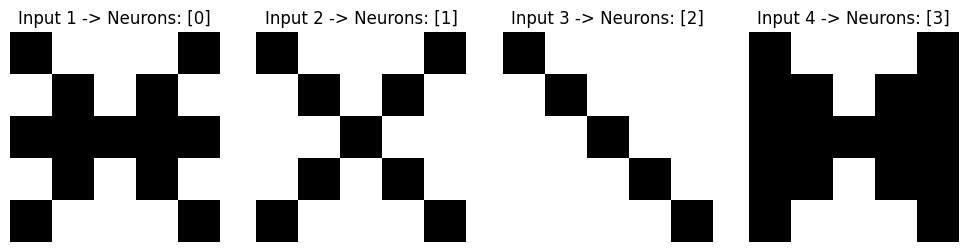

Input: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1] -> Matching Neurons: [0]
Input: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1] -> Matching Neurons: [1]
Input: [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1] -> Matching Neurons: [2]
Input: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1] -> Matching Neurons: [3]
Final weights:
Neuron 0: [0.33333333 0.         0.         0.         0.33333333 0.
 0.33333333 0.         0.33333333 0.         0.         0.
 0.33333333 0.         0.         0.         0.33333333 0.
 0.33333333 0.         0.33333333 0.         0.         0.
 0.33333333]
Neuron 1: [0.4472136 0.        0.        0.        0.        0.        0.4472136
 0.        0.        0.        0.        0.        0.4472136 0.
 0.        0.        0.        0.        0.4472136 0.        0.
 0.        0.        0.        0.4472136]
Neuron 2: [0.24253563 0.         0.        

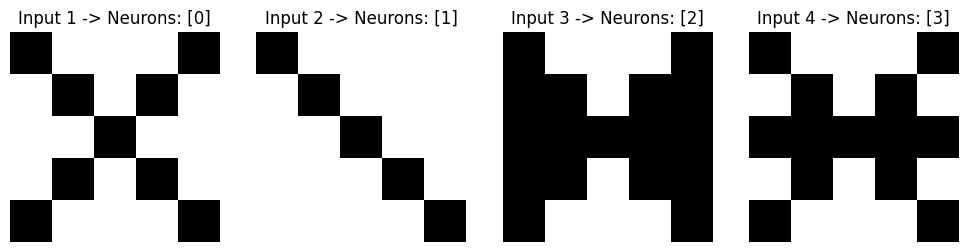

In [44]:
# Page136 例6.5.2.1

import numpy as np
import matplotlib.pyplot as plt

class ART_I:
    def __init__(self, vigilance=0.95):
        self.vigilance = vigilance
        self.weights = []
        self.num_neurons = 0

    def train(self, inputs, epochs=1):
        for epoch in range(epochs):
            # 随机打乱输入样本顺序
            np.random.shuffle(inputs)
            for input_vector in inputs:
                # Normalize input vector
                input_vector = np.array(input_vector)
                input_norm = np.linalg.norm(input_vector)
                if input_norm > 0:
                    input_vector = input_vector / input_norm

                # Find the winning neuron
                winning_neuron = None
                max_similarity = 0.0

                for i, weight in enumerate(self.weights):
                    similarity = np.dot(input_vector, weight)
                    if similarity > max_similarity:
                        max_similarity = similarity
                        winning_neuron = i

                # Check vigilance condition
                if winning_neuron is not None:
                    weight = self.weights[winning_neuron]
                    similarity = np.dot(input_vector, weight)
                    if similarity >= self.vigilance:
                        # Update the winning neuron's weight
                        self.weights[winning_neuron] = self.update_weight(input_vector, weight)
                    else:
                        # Create a new neuron
                        self.weights.append(input_vector)
                        self.num_neurons += 1
                else:
                    # Create a new neuron
                    self.weights.append(input_vector)
                    self.num_neurons += 1

    def update_weight(self, input_vector, weight):
        return (weight + input_vector) / (1 + np.sum(weight))

    def predict(self, input_vector):
        # Normalize input vector
        input_vector = np.array(input_vector)
        input_norm = np.linalg.norm(input_vector)
        if input_norm > 0:
            input_vector = input_vector / input_norm

        # Find all neurons that meet the vigilance condition
        matching_neurons = []
        for i, weight in enumerate(self.weights):
            similarity = np.dot(input_vector, weight)
            if similarity >= self.vigilance:
                matching_neurons.append(i)

        return matching_neurons

# 输入数据
x1 = [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
x2 = [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
x3 = [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
x4 = [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]

inputs = [x1, x2, x3, x4]

# 创建ART I模型
art_i = ART_I(vigilance=0.95)

# 训练模型，多次训练并随机打乱输入样本顺序
epochs = 1
art_i.train(inputs, epochs=epochs)

# 输出分类结果
predictions = []
for input_vector in inputs:
    matching_neurons = art_i.predict(input_vector)
    predictions.append(matching_neurons)
    print(f"Input: {input_vector} -> Matching Neurons: {matching_neurons}")

# 输出最终的权重矩阵
print("Final weights:")
for i, weight in enumerate(art_i.weights):
    print(f"Neuron {i}: {weight}")

# 可视化分类结果
def visualize_results(inputs, predictions, art_i, grid_size=5):
    num_inputs = len(inputs)
    fig, axes = plt.subplots(1, num_inputs, figsize=(10, 2.5))
    axes = axes.ravel()

    for i, input_vector in enumerate(inputs):
        matching_neurons = predictions[i]
        
        # 将输入向量转换为5x5矩阵
        input_matrix = np.array(input_vector).reshape(grid_size, grid_size)
        
        # 反转黑白定义
        input_matrix = 1 - input_matrix
        
        # 绘制输入向量
        axes[i].imshow(input_matrix, cmap='gray', interpolation='nearest')
        axes[i].set_title(f'Input {i+1} -> Neurons: {matching_neurons}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 调用可视化函数
visualize_results(inputs, predictions, art_i, grid_size=5)# Page136 例6.5.2.1
import numpy as np
import matplotlib.pyplot as plt

class ART_I:
    def __init__(self, vigilance=0.95):
        self.vigilance = vigilance
        self.weights = []
        self.num_neurons = 0

    def train(self, inputs, epochs=1):
        for epoch in range(epochs):
            # 随机打乱输入样本顺序
            np.random.shuffle(inputs)
            for input_vector in inputs:
                # Normalize input vector
                input_vector = np.array(input_vector)
                input_norm = np.linalg.norm(input_vector)
                if input_norm > 0:
                    input_vector = input_vector / input_norm

                # Find the winning neuron
                winning_neuron = None
                max_similarity = 0.0

                for i, weight in enumerate(self.weights):
                    similarity = np.dot(input_vector, weight)
                    if similarity > max_similarity:
                        max_similarity = similarity
                        winning_neuron = i

                # Check vigilance condition
                if winning_neuron is not None:
                    weight = self.weights[winning_neuron]
                    similarity = np.dot(input_vector, weight)
                    if similarity >= self.vigilance:
                        # Update the winning neuron's weight
                        self.weights[winning_neuron] = self.update_weight(input_vector, weight)
                    else:
                        # Create a new neuron
                        self.weights.append(input_vector)
                        self.num_neurons += 1
                else:
                    # Create a new neuron
                    self.weights.append(input_vector)
                    self.num_neurons += 1

    def update_weight(self, input_vector, weight):
        return (weight + input_vector) / (1 + np.sum(weight))

    def predict(self, input_vector):
        # Normalize input vector
        input_vector = np.array(input_vector)
        input_norm = np.linalg.norm(input_vector)
        if input_norm > 0:
            input_vector = input_vector / input_norm

        # Find all neurons that meet the vigilance condition
        matching_neurons = []
        for i, weight in enumerate(self.weights):
            similarity = np.dot(input_vector, weight)
            if similarity >= self.vigilance:
                matching_neurons.append(i)

        return matching_neurons

# 输入数据
x1 = [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
x2 = [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
x3 = [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
x4 = [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]

inputs = [x1, x2, x3, x4]

# 创建ART I模型
art_i = ART_I(vigilance=0.95)

# 训练模型，多次训练并随机打乱输入样本顺序
epochs = 1
art_i.train(inputs, epochs=epochs)

# 输出分类结果
predictions = []
for input_vector in inputs:
    matching_neurons = art_i.predict(input_vector)
    predictions.append(matching_neurons)
    print(f"Input: {input_vector} -> Matching Neurons: {matching_neurons}")

# 输出最终的权重矩阵
print("Final weights:")
for i, weight in enumerate(art_i.weights):
    print(f"Neuron {i}: {weight}")

# 可视化分类结果
def visualize_results(inputs, predictions, art_i, grid_size=5):
    num_inputs = len(inputs)
    fig, axes = plt.subplots(1, num_inputs, figsize=(10, 2.5))
    axes = axes.ravel()

    for i, input_vector in enumerate(inputs):
        matching_neurons = predictions[i]
        
        # 将输入向量转换为5x5矩阵
        input_matrix = np.array(input_vector).reshape(grid_size, grid_size)
        
        # 反转黑白定义
        input_matrix = 1 - input_matrix
        
        # 绘制输入向量
        axes[i].imshow(input_matrix, cmap='gray', interpolation='nearest')
        axes[i].set_title(f'Input {i+1} -> Neurons: {matching_neurons}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 调用可视化函数
visualize_results(inputs, predictions, art_i, grid_size=5)

#### Page 138 6.5.2.2(内容来自网上，实现更接近书中所述工作原理和过程）

样本0属于第0类

样本1属于第2类

样本2属于第1类

样本3属于第3类

样本4属于第2类

样本5属于第2类

样本6属于第2类

样本7属于第2类

样本8属于第2类

样本9属于第4类

样本10属于第3类

样本11属于第3类



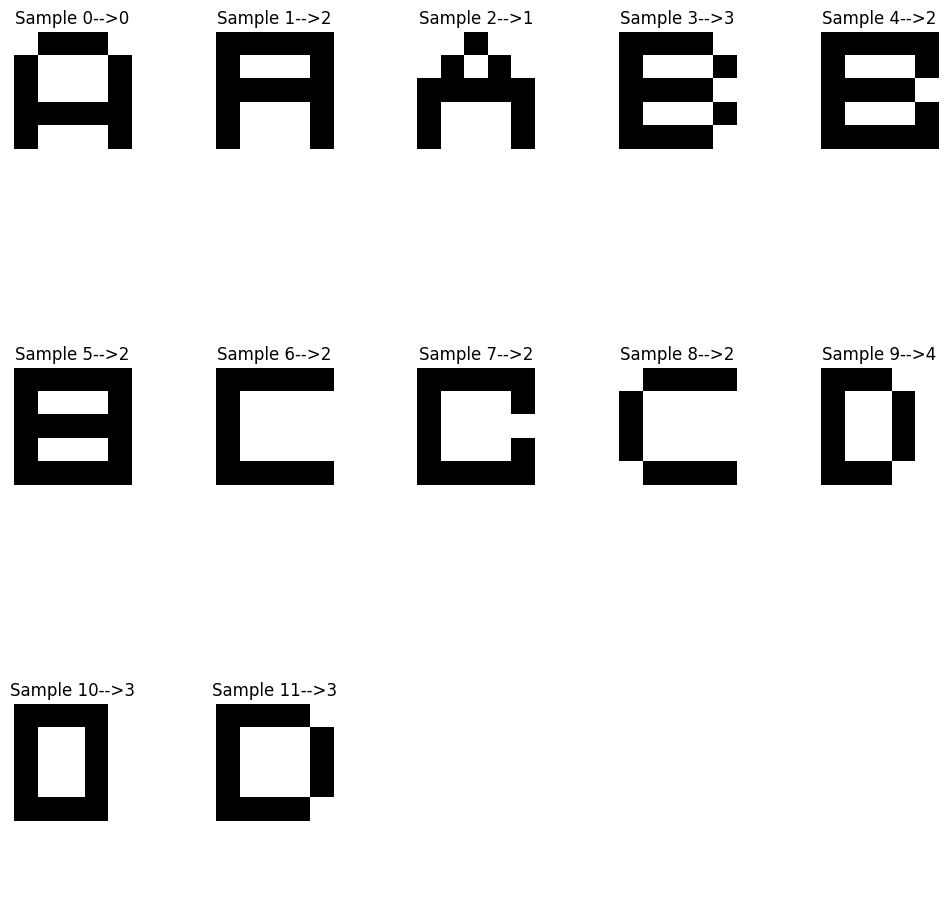

In [59]:
# Page 138 6.5.2.2(内容来自网上，实现更接近书中所述工作原理和过程）
# 基于如下网络作者程序修改
"""
ART1 神经网络练习
author Toby
"""

import numpy as np
import matplotlib.pyplot as plt

# ART 学习函数
def ART_learn(train_data_active, weight_t_active, weight_b_active, n):
    weight_t_update = train_data_active * weight_t_active
    weight_b_update = weight_t_update / (0.5 + np.sum(weight_t_update))
    return weight_t_update, weight_b_update

# ART 核心函数
def ART_core(train_data, R_node_num, weight_b, weight_t, threshold_ro, n):
    data_length, data_num = train_data.shape  # 获取训练数据的维度和数量
    result = np.zeros(data_num)  # 初始化分类结果数组

    for i in range(data_num):  # 遍历每个训练样本
        R_node = np.zeros(R_node_num)  # 初始化类别节点数组
        for _ in range(R_node_num):  # 遍历每个类别节点
            net = []  # 初始化净输入列表
            for j in range(R_node_num):  # 计算每个类别节点的净输入
                net.append(np.sum(np.dot(train_data[:, i], weight_b[:, j])))
            j_max = np.where(net == np.max(net))[0][0]  # 找到最大净输入的类别节点索引
            if R_node[j_max] == 1:  # 如果该类别节点已被激活
                net[j_max] = -n  # 将其净输入设为负值
            j_max = np.where(net == np.max(net))[0][0]  # 再次找到最大净输入的类别节点索引
            R_node[j_max] = 1  # 激活该类别节点

            weight_t_active = weight_t[:, j_max]  # 获取当前激活类别的顶部权重
            weight_b_active = weight_b[:, j_max]  # 获取当前激活类别的底部权重
            Similarity_N0 = np.sum(weight_t_active * train_data[:, i])  # 计算相似度
            Similarity_N1 = np.sum(train_data[:, i])  # 计算输入模式的总和
            flag = 1  # 标志变量，初始值为1
            if threshold_ro < Similarity_N0 / Similarity_N1:  # 如果相似度大于警觉阈值
                weight_t[:, j_max], weight_b[:, j_max] = ART_learn(train_data[:, i], weight_t_active, weight_b_active, n)  # 更新权重
                print('样本%d属于第%d类\n' % (i, j_max))  # 打印分类结果
                result[i] = j_max  # 记录分类结果
                flag = 0  # 设置标志变量为0
                break  # 结束当前样本的分类

        if flag == 1:  # 如果没有找到合适的类别
            R_node_num = R_node_num + 1  # 增加类别数
            if R_node_num == data_num + 1:  # 如果类别数超过样本数
                print('样本%d属于第%d类\n 错误: 目前的分类类别数为%d \n' % (i, R_node_num, R_node_num))
                return R_node_num, weight_b, weight_t, result  # 返回结果
            weight_b = np.column_stack((weight_b, train_data[:, i]))  # 添加新的底部权重列
            weight_t = np.column_stack((weight_t, np.ones(data_length)))  # 添加新的顶部权重列
            print('样本%d属于第%d类\n' % (i, R_node_num))  # 打印分类结果
            result[i] = R_node_num  # 记录分类结果

    return R_node_num, weight_b, weight_t, result  # 返回最终结果

# 准备训练数据
train_data = np.array([
    [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
]).T

# 初始参数设置
R_node_num = 1
weight_b = np.random.rand(25, R_node_num)
weight_t = np.ones((25, R_node_num))
threshold_ro = 0.78
n = 100  # 这个参数在函数中未使用，可以随意设置

# 调用 ART_core 函数进行分类
R_node_num, weight_b, weight_t, result = ART_core(train_data, R_node_num, weight_b, weight_t, threshold_ro, n)

# 可视化分类结果
num_samples = train_data.shape[1]
num_cols = 5  # 每行显示的图数
num_rows = (num_samples + num_cols - 1) // num_cols  # 计算需要的行数

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10.5, 3.5 * num_rows))  # 创建子图布局
fig.tight_layout(pad=3.0)  # 调整子图间距

for i in range(num_samples):
    row = i // num_cols
    col = i % num_cols
    sample = train_data[:, i].reshape(5, 5)
    sample_flipped = 1 - sample  # 将图像颜色翻转
    category = int(result[i])
    
    ax = axes[row, col] if num_rows > 1 else axes[col]  # 获取当前子图
    ax.imshow(sample_flipped, cmap='gray', interpolation='nearest')
    #ax.set_title(f'Sample {i} belongs to Category {category}')
    ax.set_title(f'Sample {i}-->{category}')
    ax.axis('off')  # 关闭坐标轴

# 如果样本数不足填满最后一行，隐藏多余的子图
for i in range(num_samples, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.show()

#### Page 138 6.5.2.2

Final weights:
Neuron 0: [0.04977468 0.04280478 0.03260235 0.0645534  0.01310557 0.07166624
 0.09805921 0.08045587 0.08600168 0.03596367 0.03248866 0.05170484
 0.00457266 0.09453581 0.01437852 0.0903013  0.00835822 0.08226249
 0.01519625 0.00381316 0.07194895 0.02802653 0.07144962 0.05550853
 0.01088074]
Neuron 1: [0.09321301 0.04523142 0.07344473 0.05010206 0.06043615 0.03027736
 0.02003603 0.05425702 0.0440219  0.03901132 0.06725672 0.06905066
 0.00459201 0.03387445 0.04117646 0.00968922 0.02359009 0.00516418
 0.09962421 0.07365572 0.00874502 0.00202494 0.07192878 0.04391922
 0.07867967]
Neuron 2: [0.0923476  0.05993004 0.01871084 0.0782194  0.09558117 0.05802313
 0.06819974 0.03374747 0.03815277 0.07346545 0.09277711 0.06289884
 0.07898479 0.0171635  0.02119591 0.05320347 0.01765542 0.06349951
 0.02916532 0.07915326 0.08081103 0.04637875 0.01808106 0.0646775
 0.0992787 ]
Neuron 3: [0.06225909 0.00357747 0.0017294  0.0320362  0.01957838 0.08130512
 0.08448057 0.02586188 0.03256448 0.

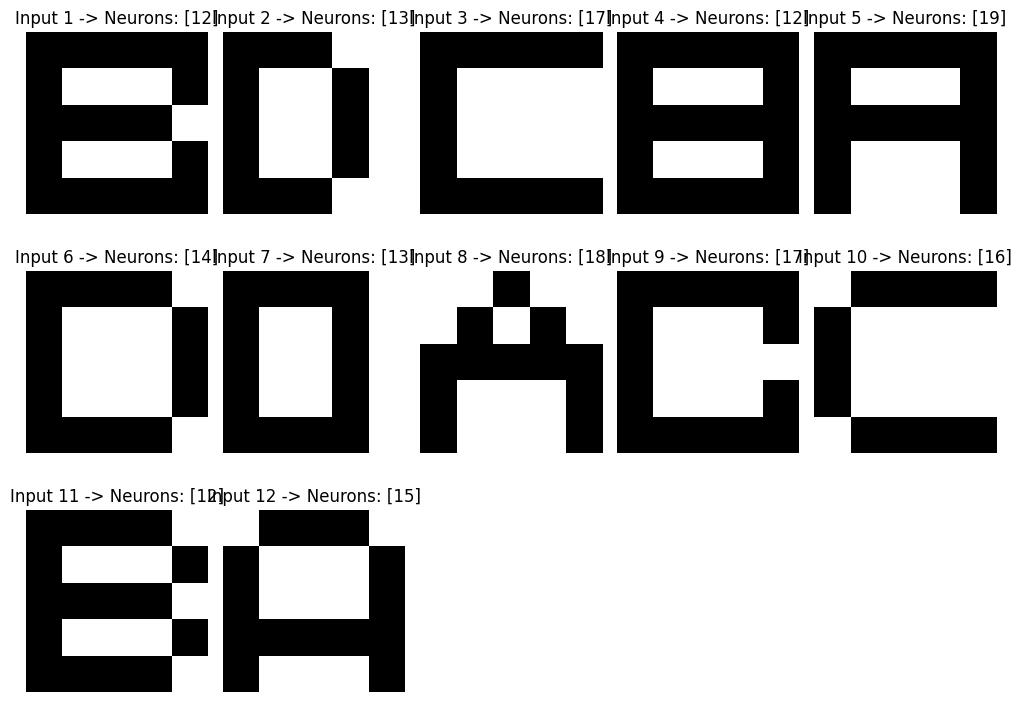

In [61]:
# Page 138 6.5.2.2

import numpy as np
import matplotlib.pyplot as plt

class ART_I:
    def __init__(self, vigilance=0.9):
        self.vigilance = vigilance
        self.weights = []
        self.num_neurons = 0

    def train(self, inputs, epochs=10):
        for epoch in range(epochs):
            np.random.shuffle(inputs)
            for input_vector in inputs:
                input_vector = np.array(input_vector)
                input_norm = np.linalg.norm(input_vector)
                if input_norm > 0:
                    input_vector = input_vector / input_norm

                winning_neuron = None
                max_similarity = 0.0

                for i, weight in enumerate(self.weights):
                    similarity = self.cosine_similarity(input_vector, weight)
                    if similarity > max_similarity:
                        max_similarity = similarity
                        winning_neuron = i

                if winning_neuron is not None:
                    weight = self.weights[winning_neuron]
                    similarity = self.cosine_similarity(input_vector, weight)
                    if similarity >= self.vigilance:
                        self.weights[winning_neuron] = self.update_weight(input_vector, weight)
                    else:
                        self.create_new_neuron(input_vector)
                else:
                    self.create_new_neuron(input_vector)

    def create_new_neuron(self, input_vector):
        # 初始化新神经元的权值为输入向量的值
        new_weight = input_vector.copy()
        # 加入小噪声
        new_weight += np.random.randn(*new_weight.shape) * 0.01
        # 归一化处理
        new_weight /= np.linalg.norm(new_weight)
        self.weights.append(new_weight)
        self.num_neurons += 1

    def update_weight(self, input_vector, weight):
        return (weight + input_vector) / (1 + np.sum(weight))

    def cosine_similarity(self, vec1, vec2):
        dot_product = np.dot(vec1, vec2)
        norm_vec1 = np.linalg.norm(vec1)
        norm_vec2 = np.linalg.norm(vec2)
        return dot_product / (norm_vec1 * norm_vec2)

    def predict(self, input_vector):
        input_vector = np.array(input_vector)
        input_norm = np.linalg.norm(input_vector)
        if input_norm > 0:
            input_vector = input_vector / input_norm

        matching_neurons = []
        for i, weight in enumerate(self.weights):
            similarity = self.cosine_similarity(input_vector, weight)
            if similarity >= self.vigilance:
                matching_neurons.append(i)

        return matching_neurons

# 输入数据
inputs = [
    [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
]

# 创建ART I模型
art_i = ART_I(vigilance=0.92)

# 初始权重设置
initial_weights = [np.random.rand(len(inputs[0])) * 0.1 for _ in range(len(inputs))]
art_i.weights = initial_weights
art_i.num_neurons = len(inputs)

# 训练模型
art_i.train(inputs, epochs=1)

# 检查未覆盖的输入向量
uncovered_inputs = []
for input_vector in inputs:
    matching_neurons = art_i.predict(input_vector)
    if not matching_neurons:
        uncovered_inputs.append(input_vector)

# 动态调整神经元数量
for input_vector in uncovered_inputs:
    art_i.create_new_neuron(input_vector)

# 再次训练模型
art_i.train(inputs, epochs=1)

# 输出最终的权重矩阵
print("Final weights:")
for i, weight in enumerate(art_i.weights):
    print(f"Neuron {i}: {weight}")

# 获取预测结果
predictions = []
for input_vector in inputs:
    matching_neurons = art_i.predict(input_vector)
    predictions.append(matching_neurons)
    print(f"Input: {input_vector} -> Matching Neurons: {matching_neurons}")

# 可视化分类结果
def visualize_results(inputs, predictions, art_i, grid_size=5):
    num_inputs = len(inputs)
    num_cols = 5  # 每行显示4个输入
    num_rows = (num_inputs + num_cols - 1) // num_cols  # 计算需要的行数

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 2.5 * num_rows))
    axes = axes.ravel()  # 将多维数组展平

    for i, input_vector in enumerate(inputs):
        matching_neurons = predictions[i]
        
        # 将输入向量转换为5x5矩阵
        input_matrix = np.array(input_vector).reshape(grid_size, grid_size)
        
        # 反转黑白定义
        input_matrix = 1 - input_matrix
        
        # 绘制输入向量
        axes[i].imshow(input_matrix, cmap='gray', interpolation='nearest')
        axes[i].set_title(f'Input {i+1} -> Neurons: {matching_neurons}')
        axes[i].axis('off')

    # 关闭多余的子图
    for j in range(num_inputs, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# 调用可视化函数
visualize_results(inputs, predictions, art_i, grid_size=5)


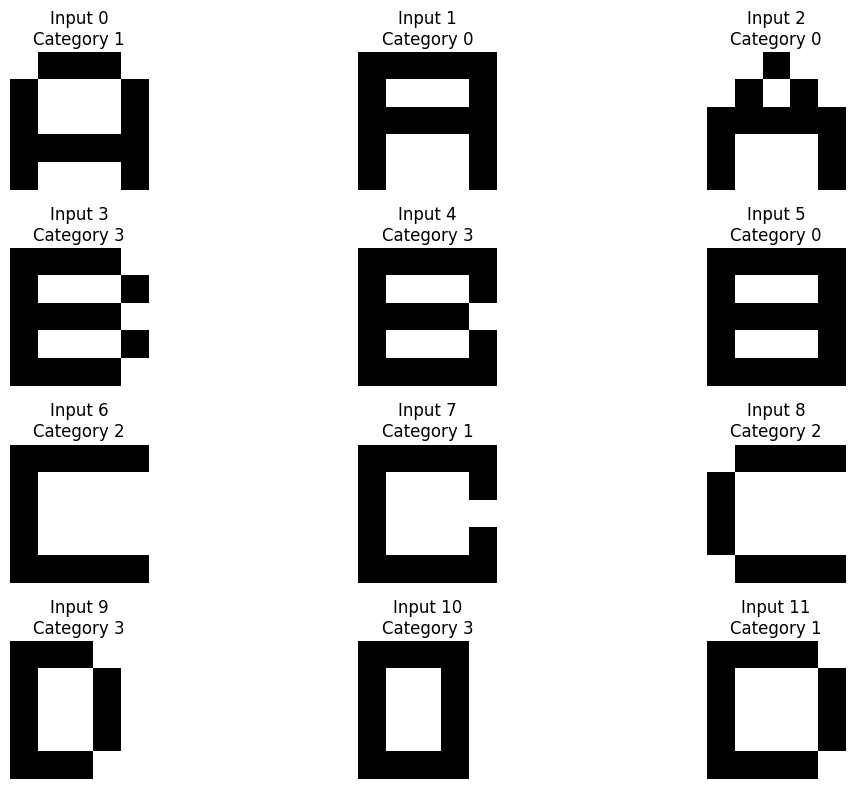

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class ART1:
    def __init__(self, num_inputs, vigilance=0.9):
        self.num_inputs = num_inputs
        self.vigilance = vigilance
        self.weights = None
        self.categories = []

    def train(self, inputs):
        if self.weights is None:
            self.weights = np.ones((1, self.num_inputs))  # 初始化权重

        for input_vector in inputs:
            input_vector = np.array(input_vector)
            normalized_input = input_vector / (1 + np.sum(input_vector))

            if len(self.categories) == 0:
                # 如果没有类别，直接添加新类别
                self.categories.append(input_vector)
                self.weights = np.vstack((self.weights, input_vector))
            else:
                # 计算相似度
                similarities = np.sum(np.minimum(self.weights, normalized_input), axis=1)
                best_match_idx = np.argmax(similarities)

                # 检查是否满足警戒条件
                if similarities[best_match_idx] / np.sum(normalized_input) >= self.vigilance:
                    # 更新权重
                    self.weights[best_match_idx] = np.minimum(self.weights[best_match_idx], input_vector)
                    # 更新类别
                    if best_match_idx >= len(self.categories):
                        self.categories.append(self.weights[best_match_idx])
                    else:
                        self.categories[best_match_idx] = self.weights[best_match_idx]
                else:
                    # 添加新类别
                    self.categories.append(input_vector)
                    self.weights = np.vstack((self.weights, input_vector))

    def classify(self, input_vector):
        input_vector = np.array(input_vector)
        normalized_input = input_vector / (1 + np.sum(input_vector))

        similarities = np.sum(np.minimum(self.weights, normalized_input), axis=1)
        best_match_idx = np.argmax(similarities)

        return best_match_idx


# 输入数据
inputs = [
    [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
]

# 创建 ART1 网络
art1 = ART1(num_inputs=25, vigilance=0.65)

# 训练网络
art1.train(inputs)

# 分类并可视化
plt.figure(figsize=(12, 8))
for i, input_vector in enumerate(inputs):
    # 将输入向量转换为 5x5 矩阵
    matrix = np.array(input_vector).reshape(5, 5)
    
    # 分类
    category = art1.classify(input_vector)
    
    # 绘制字符图像
    plt.subplot(4, 3, i + 1)
    plt.imshow(matrix, cmap='binary', vmin=0, vmax=1)
    plt.title(f'Input {i}\nCategory {category}')
    plt.axis('off')

plt.tight_layout()
plt.show()